# Cross-sectional 2D Density Distributions
In this notebook, cross-sectional 2D density distributions are calculated and plotted from trajectories of the coarse-grained model.

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os, sys, json, shutil
from math import asinh, sqrt, pi
import pandas as pd
import glob
import mdtraj as md
from mpl_toolkits.axes_grid1 import make_axes_locatable
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/giulio/Repos/SI-peptidebilayer


In [3]:
plt.rcParams.update({'font.size': 12,'xtick.major.pad':3,'ytick.major.pad':3,'figure.dpi':72,
                     'xtick.major.size':6,'ytick.major.size':6,'legend.fontsize':12,
                     'xtick.direction':'out','ytick.direction':'out','axes.labelsize':12,
                     'axes.linewidth':1.2,'xtick.labelsize':12,'ytick.labelsize':12,
                     'xtick.major.width':1.2, 'ytick.major.width':1.2})

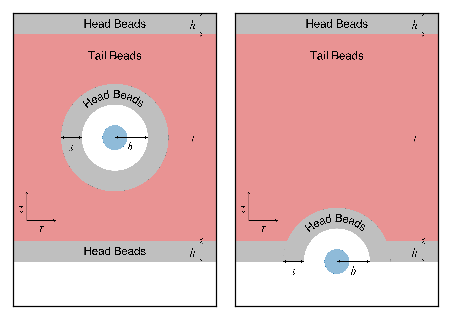

In [15]:
plt.rcParams.update({'figure.figsize': [6.5, 4.5]})
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
img=mpl.image.imread('aux/fig2a.png')
img=img[42:-200,78:]
ax1.imshow(img,interpolation='none')
img=mpl.image.imread('aux/fig2b.png')
img=img[42:-200,78:]
ax2.imshow(img,interpolation='none')
ax1.set_xticks([]); ax2.set_xticks([]); ax1.set_yticks([]); ax2.set_yticks([])
plt.tight_layout(w_pad=.1)
f.savefig('figs/figure2.png', transparent=False, dpi=1200)
plt.show()

In [4]:
# This function calculated density distributions from a CG trajectory
def density(path,sim):
    wdir = path + '/' + sim 
    edgesx = np.arange(0,3.75,.15)
    Ex = edgesx[:-1]+(edgesx[1]-edgesx[0])/2.
    edgesy = np.arange(-3.6,3.75,.15)
    Ey = edgesy[:-1]+(edgesy[1]-edgesy[0])/2.
    traj = md.load_xtc(wdir+'/traj.xtc',top=wdir+'/mpi0.confout.gro')
    lipids = traj.top.select('name HD or name TL')
    tlip = traj.atom_slice(lipids)
    com = md.compute_center_of_mass(tlip)
    aa = traj.top.select('name AA')
    taa = traj.atom_slice(aa)
    z = taa.xyz[:,0,2] - com[:,2]
    zminusL = z - traj.unitcell_lengths[:,2]
    zplusL = z + traj.unitcell_lengths[:,2]
    ### MIDPLANE ###
    # frames where the bead is at the midplane
    frames = np.arange(0,z.size)[np.abs(z)<.2]
    tmid = traj.slice(frames)
    # HEADS
    pair_c2cat = tmid.top.select_pairs('name AA','name HD')
    v = md.compute_displacements(tmid,pair_c2cat)
    v = v.reshape((v.shape[0]*v.shape[1],v.shape[2]))
    x0 = v[:,0]; y0 = v[:,1]; z0 = v[:,2]
    R = np.sqrt(y0*y0+x0*x0)
    h, edges, edges = np.histogram2d(z0,R,bins=[edgesy,edgesx])
    # jacobian correction
    jacobian = pi*.15*np.tile((Ex+.15/2.)[:,np.newaxis]**2-(Ex-.15/2.)[:,np.newaxis]**2,Ey.size)[:,::-1].T
    h = h/jacobian
    Prob = np.append(h[:,::-1],h,axis=1)
    Prob = Prob / tmid.n_frames 
    df = pd.DataFrame(data=Prob,index=Ey,columns=np.append(-Ex[::-1],Ex))
    df.to_pickle(sim + '/mid2dHD.p')
    # TAILS
    pair_c2cat = tmid.top.select_pairs('name AA','name TL')
    v = md.compute_displacements(tmid,pair_c2cat)
    v = v.reshape((v.shape[0]*v.shape[1],v.shape[2]))
    x0 = v[:,0]; y0 = v[:,1]; z0 = v[:,2]
    R = np.sqrt(y0*y0+x0*x0)
    h, edges, edges = np.histogram2d(z0,R,bins=[edgesy,edgesx])
    # jacobian correction
    h = h/jacobian
    Prob = np.append(h[:,::-1],h,axis=1)
    Prob = Prob / tmid.n_frames 
    df = pd.DataFrame(data=Prob,index=Ey,columns=np.append(-Ex[::-1],Ex))
    df.to_pickle(sim + '/mid2dTL.p')
    ### INTERFACE ###
    edgesy = np.arange(-3.6,3.75,.15)+2.45
    Ey = edgesy[:-1]+(edgesy[1]-edgesy[0])/2.
    z[z>traj.unitcell_lengths[:,2]/2.] = zminusL[z>traj.unitcell_lengths[:,2]/2.]
    z[z<-traj.unitcell_lengths[:,2]/2.] = zplusL[z<-traj.unitcell_lengths[:,2]/2.]
    # frames where the bead is at the bottom interface
    frames = np.arange(0,z.size)[(z>-2.5)*(z<-2.4)]
    tint = traj.slice(frames)   
    # HEADS 
    pair_c2cat = tint.top.select_pairs('name AA','name HD')
    v = md.compute_displacements(tint,pair_c2cat)
    v = v.reshape((v.shape[0]*v.shape[1],v.shape[2]))
    x0 = v[:,0]; y0 = v[:,1]; z0 = v[:,2]
    R = np.sqrt(y0*y0+x0*x0)
    h1, edges, edges = np.histogram2d(z0,R,bins=[edgesy,edgesx])
    h1 = h1 / tint.n_frames
    # TAILS
    pair_c2cat = tint.top.select_pairs('name AA','name TL')
    v = md.compute_displacements(tint,pair_c2cat)
    v = v.reshape((v.shape[0]*v.shape[1],v.shape[2]))
    x0 = v[:,0]; y0 = v[:,1]; z0 = v[:,2]
    R = np.sqrt(y0*y0+x0*x0)
    h3, edges, edges = np.histogram2d(z0,R,bins=[edgesy,edgesx])
    h3 = h3 / tint.n_frames
    # frames where the bead is at the top interface
    frames = np.arange(0,z.size)[(z<2.5)*(z>2.4)]
    tint = traj.slice(frames)
    # HEADS
    pair_c2cat = tint.top.select_pairs('name AA','name HD')
    v = md.compute_displacements(tint,pair_c2cat)
    v = v.reshape((v.shape[0]*v.shape[1],v.shape[2]))
    x0 = v[:,0]; y0 = v[:,1]; z0 = v[:,2]
    R = np.sqrt(y0*y0+x0*x0)
    h2, edges, edges = np.histogram2d(z0,R,bins=[-edgesy[::-1],edgesx])
    h2 = h2 / tint.n_frames
    # TAILS
    pair_c2cat = tint.top.select_pairs('name AA','name TL')
    v = md.compute_displacements(tint,pair_c2cat)
    v = v.reshape((v.shape[0]*v.shape[1],v.shape[2]))
    x0 = v[:,0]; y0 = v[:,1]; z0 = v[:,2]
    R = np.sqrt(y0*y0+x0*x0)
    h4, edges, edges = np.histogram2d(z0,R,bins=[-edgesy[::-1],edgesx])
    h4 = h4 / tint.n_frames
    h = (h1 + h2[::-1,:])/2
    h = h / jacobian
    Prob = np.append(h[:,::-1],h,axis=1)
    df = pd.DataFrame(data=Prob,index=Ey,columns=np.append(-Ex[::-1],Ex))
    df.to_pickle(sim + '/int2dHD.p')
    h = (h3 + h4[::-1,:])/2
    h = h / jacobian
    Prob = np.append(h[:,::-1],h,axis=1)
    df = pd.DataFrame(data=Prob,index=Ey,columns=np.append(-Ex[::-1],Ex))
    df.to_pickle(sim + '/int2dTL.p')

In [5]:
def plotting(sub,sim,filename,vmin,vmax):
    d = pd.read_pickle(sim+'/'+filename+'2dTL.p')
    Prob = d.values; Ey = d.index ; Ex = d.columns
    im2 = sub.imshow(Prob,extent=[Ex.min(), Ex.max(), Ey.min(), Ey.max()], interpolation='bicubic',
                   cmap=plt.cm.Reds,vmin=vmin,vmax=vmax,origin='lower',alpha=1,aspect='auto')
    d = pd.read_pickle(sim+'/'+filename+'2dHD.p')
    Prob = d.values; Ey = d.index ; Ex = d.columns
    im1 = sub.imshow(Prob,extent=[Ex.min(), Ex.max(), Ey.min(), Ey.max()], interpolation='bicubic',
                   cmap=plt.cm.Greys,vmin=vmin,vmax=vmax,origin='lower',alpha=.8,aspect='auto')
    return im1,im2

### Cross-sectional 2D Density Distributions of Head and Tail Beads: Translocation of a Lysine Monopeptide

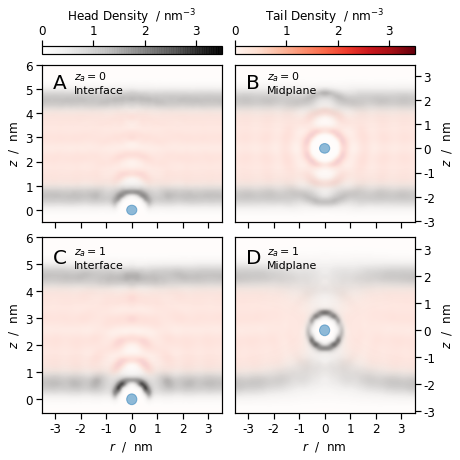

In [6]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': [6.5,6.5]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
dmax=3.5
imHD, im2 = plotting(ax1,'coarsegrained/0_25_-35_2_2','int',0,dmax)
im1, imTL = plotting(ax2,'coarsegrained/0_25_-35_2_2','mid',0,dmax)
plotting(ax3,'coarsegrained/1_25_-35_2','int',0,dmax)
plotting(ax4,'coarsegrained/1_25_-35_2','mid',0,dmax)
for ax in f.axes:
    ax.set_xticks(np.arange(-3,3.5,1))
ax1.set_xticklabels(np.tile([''],4))
ax2.set_xticklabels(np.tile([''],4))
ax3.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax4.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax1.set_ylim(-.5,6); ax2.set_ylim(-3.05,3.45)
ax3.set_ylim(-.5,6); ax4.set_ylim(-3.05,3.45)
ax1.set_yticks(np.arange(0,6.5,1)); ax2.set_yticks(np.arange(-3,3.5,1))
ax3.set_yticks(np.arange(0,6.5,1)); ax4.set_yticks(np.arange(-3,3.5,1))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(0,6.5,1))
ax2.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(0,6.5,1))
ax4.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax3.set_xlabel('$r$  /  nm'); ax4.set_xlabel('$r$  /  nm')
for ax in f.axes:
    ax.set_ylabel('$z$  /  nm')
ax2.yaxis.set_ticks_position('right'); ax4.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right'); ax4.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate('$z_a=0$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax2.annotate('$z_a=0$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax3.annotate('$z_a=1$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax4.annotate('$z_a=1$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imHD, cax=cax, orientation="horizontal", label=r'Head Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imTL, cax=cax, orientation="horizontal", label=r'Tail Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

blue = '#96B7D2'

circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax1.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax2.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax3.add_artist(circle)
circle = plt.Circle((0, 0),0.2,color=colors[0],alpha=.5)
ax4.add_artist(circle)

f.tight_layout(w_pad=.1,h_pad=.2)    
f.savefig('figs/density.pdf')
plt.show()

### Cross-sectional 2D Density Distributions of Head and Tail Beads: Translocation of an Amino Acid Strongly Attracted to the Head Groups

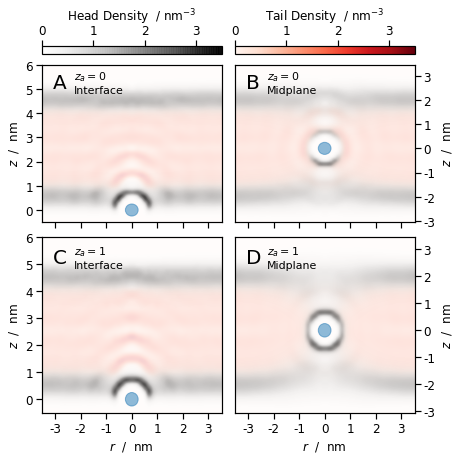

In [7]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': [6.5,6.5]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
dmax=3.5
imHD, im2 = plotting(ax1,'coarsegrained/0_35_-35_2.5_3','int',0,dmax)
im1, imTL = plotting(ax2,'coarsegrained/0_35_-35_2.5_3','mid',0,dmax)
plotting(ax3,'coarsegrained/1_35_-35_2.5','int',0,dmax)
plotting(ax4,'coarsegrained/1_35_-35_2.5','mid',0,dmax)
for ax in f.axes:
    ax.set_xticks(np.arange(-3,3.5,1))
ax1.set_xticklabels(np.tile([''],4))
ax2.set_xticklabels(np.tile([''],4))
ax3.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax4.set_xticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax1.set_ylim(-.5,6); ax2.set_ylim(-3.05,3.45)
ax3.set_ylim(-.5,6); ax4.set_ylim(-3.05,3.45)
ax1.set_yticks(np.arange(0,6.5,1)); ax2.set_yticks(np.arange(-3,3.5,1))
ax3.set_yticks(np.arange(0,6.5,1)); ax4.set_yticks(np.arange(-3,3.5,1))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(0,6.5,1))
ax2.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(0,6.5,1))
ax4.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,3.5,1))
ax3.set_xlabel('$r$  /  nm'); ax4.set_xlabel('$r$  /  nm')
for ax in f.axes:
    ax.set_ylabel('$z$  /  nm')
ax2.yaxis.set_ticks_position('right'); ax4.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right'); ax4.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate('$z_a=0$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax2.annotate('$z_a=0$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax3.annotate('$z_a=1$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax4.annotate('$z_a=1$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imHD, cax=cax, orientation="horizontal", label=r'Head Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(imTL, cax=cax, orientation="horizontal", label=r'Tail Density  / nm$^{-3}$', 
                ticks=np.arange(0,dmax+.5,1))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(0,dmax+.5,1)])

blue = '#96B7D2'

circle = plt.Circle((0, 0),0.25,color=colors[0],alpha=.5)
ax1.add_artist(circle)
circle = plt.Circle((0, 0),0.25,color=colors[0],alpha=.5)
ax2.add_artist(circle)
circle = plt.Circle((0, 0),0.25,color=colors[0],alpha=.5)
ax3.add_artist(circle)
circle = plt.Circle((0, 0),0.25,color=colors[0],alpha=.5)
ax4.add_artist(circle)

f.tight_layout(w_pad=.1,h_pad=.2)    
f.savefig('figs/density2.pdf')
plt.show()